<a href="https://colab.research.google.com/github/Hitesh-Nagothu/Covid_npi_research/blob/master/SIR_County_Simulation_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd
import os
import datetime
import numpy as np

In [34]:
population_path='/content/drive/MyDrive/NPI/county/population.csv'
cases_path='/content/drive/MyDrive/NPI/county/us-counties.csv'
mobility_path= '/content/drive/MyDrive/NPI/county/mobility.csv'

In [35]:
population=pd.read_csv(population_path, dtype=str)
cases=pd.read_csv(cases_path, dtype=str)
mobility=pd.read_csv(mobility_path, dtype=str)

In [36]:
#processing population
def fix_fips_county(code):
  n=len(code)
  if n==1:
    code="00"+code
  elif n==2:
    code="0"+code
  else:
    pass
  return code

def fix_fips_state(code):
  n=len(code)
  if n==1:
    code="0"+code
  elif n==2:
    pass  
  return code

def zip(state,county):
  return state+county

population['COUNTY FIPS']=population['COUNTY FIPS'].apply(lambda k: fix_fips_county(k))
population['STATE FIPS']=population['STATE FIPS'].apply(lambda k: fix_fips_state(k))
population['ZIP']=population.apply(lambda row: zip(row['STATE FIPS'], row['COUNTY FIPS']), axis=1)
population=population.drop(columns=['Unnamed: 0', '2010 POPULATION', 'LAND AREA (Sqare Miles)', 'STATE FIPS', 'COUNTY FIPS', 'STATE/TERRITORY NAME','COUNTY NAME'], axis=1)


In [37]:
#processing cases
cases['date']=pd.to_datetime(cases['date'], format='%Y-%m-%d')
#start_date=datetime.datetime.strptime('2020-10-31','%Y-%m-%d')
#end_date=datetime.datetime.strptime('2020-12-01','%Y-%m-%d')
start_date='2020-10-31'
end_date='2020-12-01'

cases=cases[(cases['date']>start_date) & (cases['date']<end_date)]

def get_day(date):
  date_str=date.strftime('%Y-%m-%d')
  day=date_str.split('-')[2]
  return day

cases['day']=cases['date'].apply(lambda date: get_day(date))
#cases=cases.drop(columns=['county','state','deaths'], axis=1)

In [38]:
#processing mobility
def fix_fips(code):
  if len(code)==4:
    code="0"+code
  return int(code)

mobility['date']=pd.to_datetime(mobility['date'], format='%Y-%m-%d')
start_date=datetime.datetime.strptime('2020-10-31','%Y-%m-%d')
end_date=datetime.datetime.strptime('2020-12-1','%Y-%m-%d')
mobility=mobility[(mobility['date']>start_date) & (mobility['date']<end_date)]
mobility['day']=mobility['date'].apply(lambda date: get_day(date))
mobility=mobility.drop(columns=['lat_d','lat_o', 'lng_d', 'lng_o','visitor_flows'], axis=1)

In [39]:
mobility['geoid_o']=mobility['geoid_o'].apply(lambda code: code.zfill(5))
mobility['geoid_d']=mobility['geoid_d'].apply(lambda code: code.zfill(5))

In [40]:
filter_mobilty=mobility.rename(columns={'geoid_o':'Origin', 'geoid_d':'Destination', 'day':'Day', 'pop_flows':'Mobility Index'})
filter_mobilty=filter_mobilty.drop(['date'], axis=1)

mobility_fips=list(filter_mobilty.Origin.unique())
population_fips=list(filter_population.ZIP.unique())
cases_fips=list(cases.fips.unique())

final_fips_codes=[]
for i in cases_fips:
  if i in mobility_fips and i in population_fips:
    final_fips_codes.append(i)

filter_population=population[population.ZIP.isin(final_fips_codes)]
filter_mobilty=filter_mobilty[filter_mobilty.Origin.isin(final_fips_codes)]

3210

In [44]:
final_df=pd.DataFrame()
cases_matrix=[]
for f in final_fips_codes:
  df=cases[cases.fips==f]
  df=df.sort_values('day')
  df['cases']=df['cases'].astype(int)
  final_df=final_df.append(df)
  cases_matrix.append(list(df['cases']))

case_values = np.zeros([len(cases_matrix),len(max(cases_matrix,key = lambda x: len(x)))])
for i,j in enumerate(cases_matrix):
    case_values[i][0:len(j)] = j

case_values=case_values.T.tolist()

In [45]:
final_cases=pd.DataFrame(case_values,columns=final_fips_codes)

In [49]:
final_cases.shape

(30, 3210)

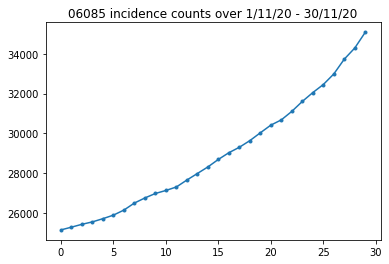

In [50]:
import matplotlib.pyplot as plt

plt.plot(final_cases['06085'], '.-')
plt.title('06085 incidence counts over 1/11/20 - 30/11/20')
plt.show()

In [59]:
filter_population=filter_population.rename(columns={'ZIP':'fips', '2015 POPULATION':'Population'})

In [62]:
with open('/content/drive/MyDrive/NPI/mobility_final.csv', 'w') as f:
  f.write(filter_mobilty.to_csv())
  f.close()

with open('/content/drive/MyDrive/NPI/population_final.csv', 'w') as f:
  f.write(filter_population.to_csv())
  f.close()

with open('/content/drive/MyDrive/NPI/cases_final.csv', 'w') as f:
  f.write(final_cases.to_csv())
  f.close()